In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from nets import *
from cfgs import *
from data import *
from trainer import *

In [2]:
%matplotlib inline
save_plot = False
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
D = 201

x = np.linspace(0, 2.0, D)
X_tst = np.stack([v.flatten() for v in np.meshgrid(x,x)], axis = -1)
print(X_tst.shape)

cfg = additive_1x2_gamma_0_9_config.cfg
cfg.test.batch_size = D
cfg.test.num_batches = int(X_tst.shape[0]/cfg.test.batch_size)
cfg.test.save_output = True

(40401, 2)


In [3]:
Net = additive_net.Net
Generator = gamma_0_9_generator.Generator
Trainer = trainer.Trainer

In [4]:
net = Net(cfg, "test")
generator = Generator(cfg, 'test', X_tst)
m = Trainer(cfg, "test", net)
m.test(generator)

2025-11-10 05:34:26,231:INFO:TEST ALL-400000: t = 0.2037, Net_Loss: -1.069617, Revenue: 1.069617


In [5]:
alloc = np.load(os.path.join(cfg.dir_name, "alloc_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D,D,2)
pay = np.load(os.path.join(cfg.dir_name, "pay_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D,D)

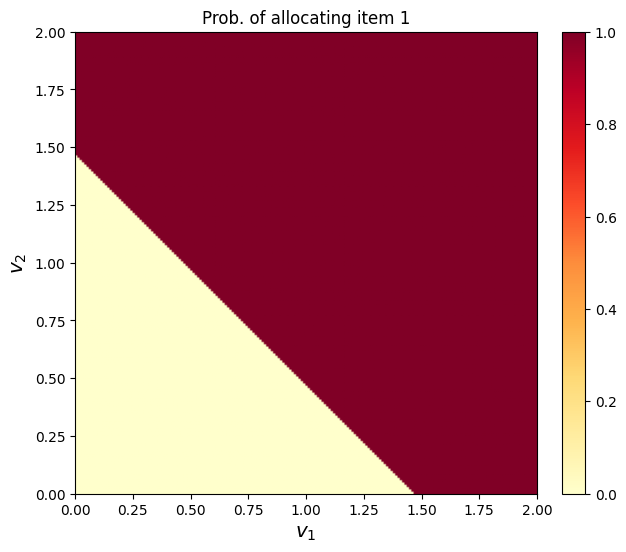

In [6]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))

img = ax.imshow(alloc[::-1, :, 0], extent=[0,2,0,2], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd')
                    
ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title('Prob. of allocating item 1')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc1.pdf'), bbox_inches = 'tight', pad_inches = 0.05)

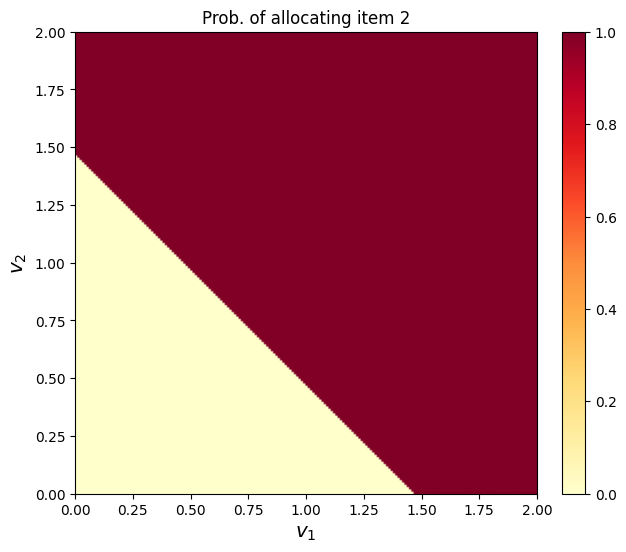

In [7]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))

img = ax.imshow(alloc[::-1, :, 1], extent=[0,2,0,2], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd')
              
ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title('Prob. of allocating item 2')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc2.pdf'), bbox_inches = 'tight', pad_inches = 0.05)

In [ ]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))

img = ax.imshow(pay[::-1, :], extent=[0,2,0,2], cmap = 'YlOrRd')
              
ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title('Payment')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'pay.pdf'), bbox_inches = 'tight', pad_inches = 0.05)
